In [1]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

D:\AdvanceIDE\Anaconda3\envs\mlenv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### parameters

In [2]:
random_seed = 123
learning_rate = 0.001
batch_size = 128
epochs = 10

num_classes = 10
num_features = 32*32

grayscale = True

### data

In [5]:
resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])

train_dataset = datasets.MNIST("D:/work/data/Python/mnist/",
                               train=True,
                               transform=resize_transform,
                               download=True)
test_dataset = datasets.MNIST("D:/work/data/Python/mnist/",
                              train=False,
                              transform=resize_transform,
                              download=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

for images, labels in train_loader:
    print("images shape: ", images.size())
    print("labels shape: ", labels.size())
    break

images shape:  torch.Size([128, 1, 32, 32])
labels shape:  torch.Size([128])


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(random_seed)
for epoch in range(2):
    for batch_idx, (x, y) in enumerate(train_loader):
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

cuda
Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


### model

In [17]:
class LeNet5(nn.Module):
    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes
        
        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=(5, 5), stride=(1, 1)),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=(5, 5)),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        
        return logits, probas

In [18]:
torch.manual_seed(random_seed)

model = LeNet5(num_classes, grayscale)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### train

'''
a = torch.randn(3, 4)
torch.max(a, dim=1, keepdim=True)
'''

In [19]:
def accuracy(model, dataloader):
    correct, num_samples = 0, 0
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)
        
        logits, probas = model(features)
        _, predict_labels = torch.max(probas, 1)
        
        num_samples += targets.size(0)
        correct += (predict_labels == targets).sum()
    
    return correct.float() / num_samples * 100

start_time = time.time()
for epoch in range(epochs):
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)
        
        # forward
        optimizer.zero_grad()
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        
        # backward
        cost.backward()
        
        # update
        optimizer.step()
        
        if (batch_idx + 1) % 50 == 0:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, epochs, batch_idx, 
                     len(train_loader), cost))
model.eval()
with torch.no_grad(): # save memory during inference
    print('Epoch: %03d/%03d | Train: %.3f%%' % (
          epoch+1, epochs, 
          accuracy(model, train_loader)))

Epoch: 001/010 | Batch 0049/0469 | Cost: 0.6444
Epoch: 001/010 | Batch 0099/0469 | Cost: 0.2702
Epoch: 001/010 | Batch 0149/0469 | Cost: 0.2010
Epoch: 001/010 | Batch 0199/0469 | Cost: 0.2603
Epoch: 001/010 | Batch 0249/0469 | Cost: 0.1589
Epoch: 001/010 | Batch 0299/0469 | Cost: 0.1135
Epoch: 001/010 | Batch 0349/0469 | Cost: 0.0882
Epoch: 001/010 | Batch 0399/0469 | Cost: 0.1276
Epoch: 001/010 | Batch 0449/0469 | Cost: 0.0613
Epoch: 002/010 | Batch 0049/0469 | Cost: 0.1042
Epoch: 002/010 | Batch 0099/0469 | Cost: 0.0210
Epoch: 002/010 | Batch 0149/0469 | Cost: 0.0292
Epoch: 002/010 | Batch 0199/0469 | Cost: 0.1092
Epoch: 002/010 | Batch 0249/0469 | Cost: 0.0227
Epoch: 002/010 | Batch 0299/0469 | Cost: 0.0551
Epoch: 002/010 | Batch 0349/0469 | Cost: 0.0522
Epoch: 002/010 | Batch 0399/0469 | Cost: 0.0267
Epoch: 002/010 | Batch 0449/0469 | Cost: 0.1903
Epoch: 003/010 | Batch 0049/0469 | Cost: 0.0329
Epoch: 003/010 | Batch 0099/0469 | Cost: 0.0459
Epoch: 003/010 | Batch 0149/0469 | Cost:

### evaluate

In [21]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (accuracy(model, test_loader)))

Test accuracy: 99.00%


torch.Size([128, 1, 32, 32])
torch.Size([128])
torch.Size([32, 32, 1])
(32, 32)


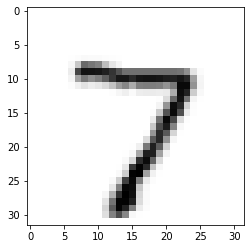

In [24]:
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features
    targets = targets
    break

print(features.size())
print(targets.size())
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
print(nhwc_img.size())
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
print(nhw_img.shape)
plt.imshow(nhw_img, cmap='Greys')